## Data Exploration

This notebook performs exploratory data analysis (EDA) of the preprocessed dataset that was produced by the previous notebook (00). The dataset has already undergone some exploration to handle missing values and convert the twice-hourly sensor data to a set of relevant features that have been aligned with the most likely sighting window for 'nshor'. 

The main objectives are to:

1. Understand the structure and basic statistics of the data.
2. Visualise the distribution of key variables.
3. Explore temporal trends and relationships between variables.
4. Identify potential anomalies or outliers in the dataset.
5. Uncover correlations and patterns among variables, with a view to reducing the feature set.

**-- Findings --**

1. Variable Distributions
- Most variables, including 'WVHT_max' (wave height maximum), 'APD_mean' (average peak wave period), and 'wave_power', exhibit right-skewed distributions.
- 'MWD_at_peak' (mean wave direction at peak period) and 'DPD_at_peak' (dominant wave period at peak) show multimodal distributions.
- The target variable 'nshor' is right-skewed, indicating more frequent occurrences of lower surf heights.

2. Temporal Patterns
- Clear seasonal patterns are observed in key variables:
  - 'WVHT_max', 'wave_power', and 'nshor' show higher values during winter months.
  - 'APD_mean' and 'DPD_at_peak' display longer periods in winter.
- 'MWD_at_peak' exhibits cyclical patterns, possibly related to seasonal wind direction changes.

3. Feature Correlations
- The top features correlated with 'nshor' are:
  1. 'WVHT_max_DPD_mean_interact' (interaction term)
  2. 'WVHT_max_APD_interact_log^2' (transformed interaction term)
  3. 'wave_power'
  4. 'WVHT_max'
  5. 'APD_mean'
- High correlation of interaction terms suggests non-linear relationships between wave characteristics and surf height.

4. Feature Relationships
- Strong positive correlations exist between interaction terms and 'nshor'.
- 'Wave_power' shows a clear positive relationship with 'nshor', with some non-linearity at higher values.
- 'WVHT_max' and 'APD_mean' display positive correlations with 'nshor', with increasing spread at higher values.

5. Outlier Analysis
- Approximately 1% of data points were identified as outliers using Isolation Forest.
- Outliers primarily occur during extreme wave events, often in winter months.
- These anomalies possibly represent significant storm events or unusual surf conditions.
- Modelling performance on this specific dataset could be improved by removing outliers. However, since predicting larger waves is
of particular interest to surfers, these datapoints are a key feature of the data and as such have been retained, although it is
assumed that far more data would be required to accurately model these surf conditions.

Key Insights
1. Wave power and maximum wave height, along with their interactions, are strong predictors of observed surf heights.
2. Seasonal patterns significantly influence surf conditions, with winter periods generally showing higher surf heights and wave power.
3. The relationship between wave characteristics and surf height is complex and non-linear, as evidenced by the high correlation of interaction terms.
4. Extreme events, represented by outliers, play a crucial role in understanding and predicting unusually high surf conditions.

Recommendations for Further Analysis
1. Develop non-linear models to capture the complex relationships between variables.
2. Consider separate modelling approaches for extreme events and regular conditions.
3. Explore time-series specific techniques, such as lagged variables and Fourier analysis, to capture temporal dependencies and cyclical patterns (not yet done).

## Import Libraries and Dataset

In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import IsolationForest

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the preprocessed data
df = pd.read_csv('~/Projects/surfline/data/preprocessed.dat', index_col=0, parse_dates=True)
print(f"Data shape: {df.shape}")
df.head()

Data shape: (2480, 30)


,WVHT_max,DPD_at_peak,DPD_mean,APD_mean,MWD_at_peak,MWD_mean,wave_power,WVHT_max_2d_avg,MWD_2d_avg,APD_2d_avg,...,APD_2d_avg_log,wave_power_2d_avg_log,WVHT_max_3d_avg_log,MWD_wave_power_interact_log,nshor,DPD_mean_wave_power_interact^2,WVHT_max_APD_interact^2,WVHT_max_APD_interact_log^2,day_cos,is_winter
2010-01-02,1.96,15.38,14.656923,9.327692,314.0,323.153846,22.266190,2.120,323.0,8.950,...,2.297573,3.227629,1.210948,8.852605,7.0,1.065068e+05,425.151409,9.446905,0.999408,1
2010-01-03,1.84,14.29,13.714000,8.068000,319.0,315.400000,17.074506,1.900,316.5,9.870,...,2.386007,3.028700,1.107462,8.602961,6.0,5.483080e+04,287.804439,8.342937,0.998669,1
2010-01-04,2.15,11.11,11.024000,7.234000,312.0,313.600000,22.357752,1.995,315.5,8.325,...,2.232699,3.030913,1.093041,8.850320,6.0,6.074838e+04,255.184650,8.018594,0.997634,1
2010-01-05,4.20,14.29,14.082500,11.030000,325.0,323.083333,89.029218,3.175,318.5,9.545,...,2.355652,4.037659,1.316408,10.272824,18.0,1.571899e+06,2398.256784,15.299542,0.996303,1
2010-01-06,3.47,16.67,15.913750,11.696250,308.0,309.375000,81.988436,3.835,316.5,11.965,...,2.562253,4.460246,1.452394,10.136718,15.0,1.702356e+06,1812.792414,14.247056,0.994678,1


# Data Overview

In [3]:
# Display basic information about the dataset
print(df.info())

# Display summary statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2480 entries, 2010-01-02 to 2016-12-31
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   WVHT_max                        2480 non-null   float64
 1   DPD_at_peak                     2480 non-null   float64
 2   DPD_mean                        2480 non-null   float64
 3   APD_mean                        2480 non-null   float64
 4   MWD_at_peak                     2480 non-null   float64
 5   MWD_mean                        2480 non-null   float64
 6   wave_power                      2480 non-null   float64
 7   WVHT_max_2d_avg                 2480 non-null   float64
 8   MWD_2d_avg                      2480 non-null   float64
 9   APD_2d_avg                      2480 non-null   float64
 10  DPD_mean_2d_avg                 2480 non-null   float64
 11  wave_power_2d_avg               2480 non-null   float64
 12  WVHT_max_3d_avg 

## Data Distributions

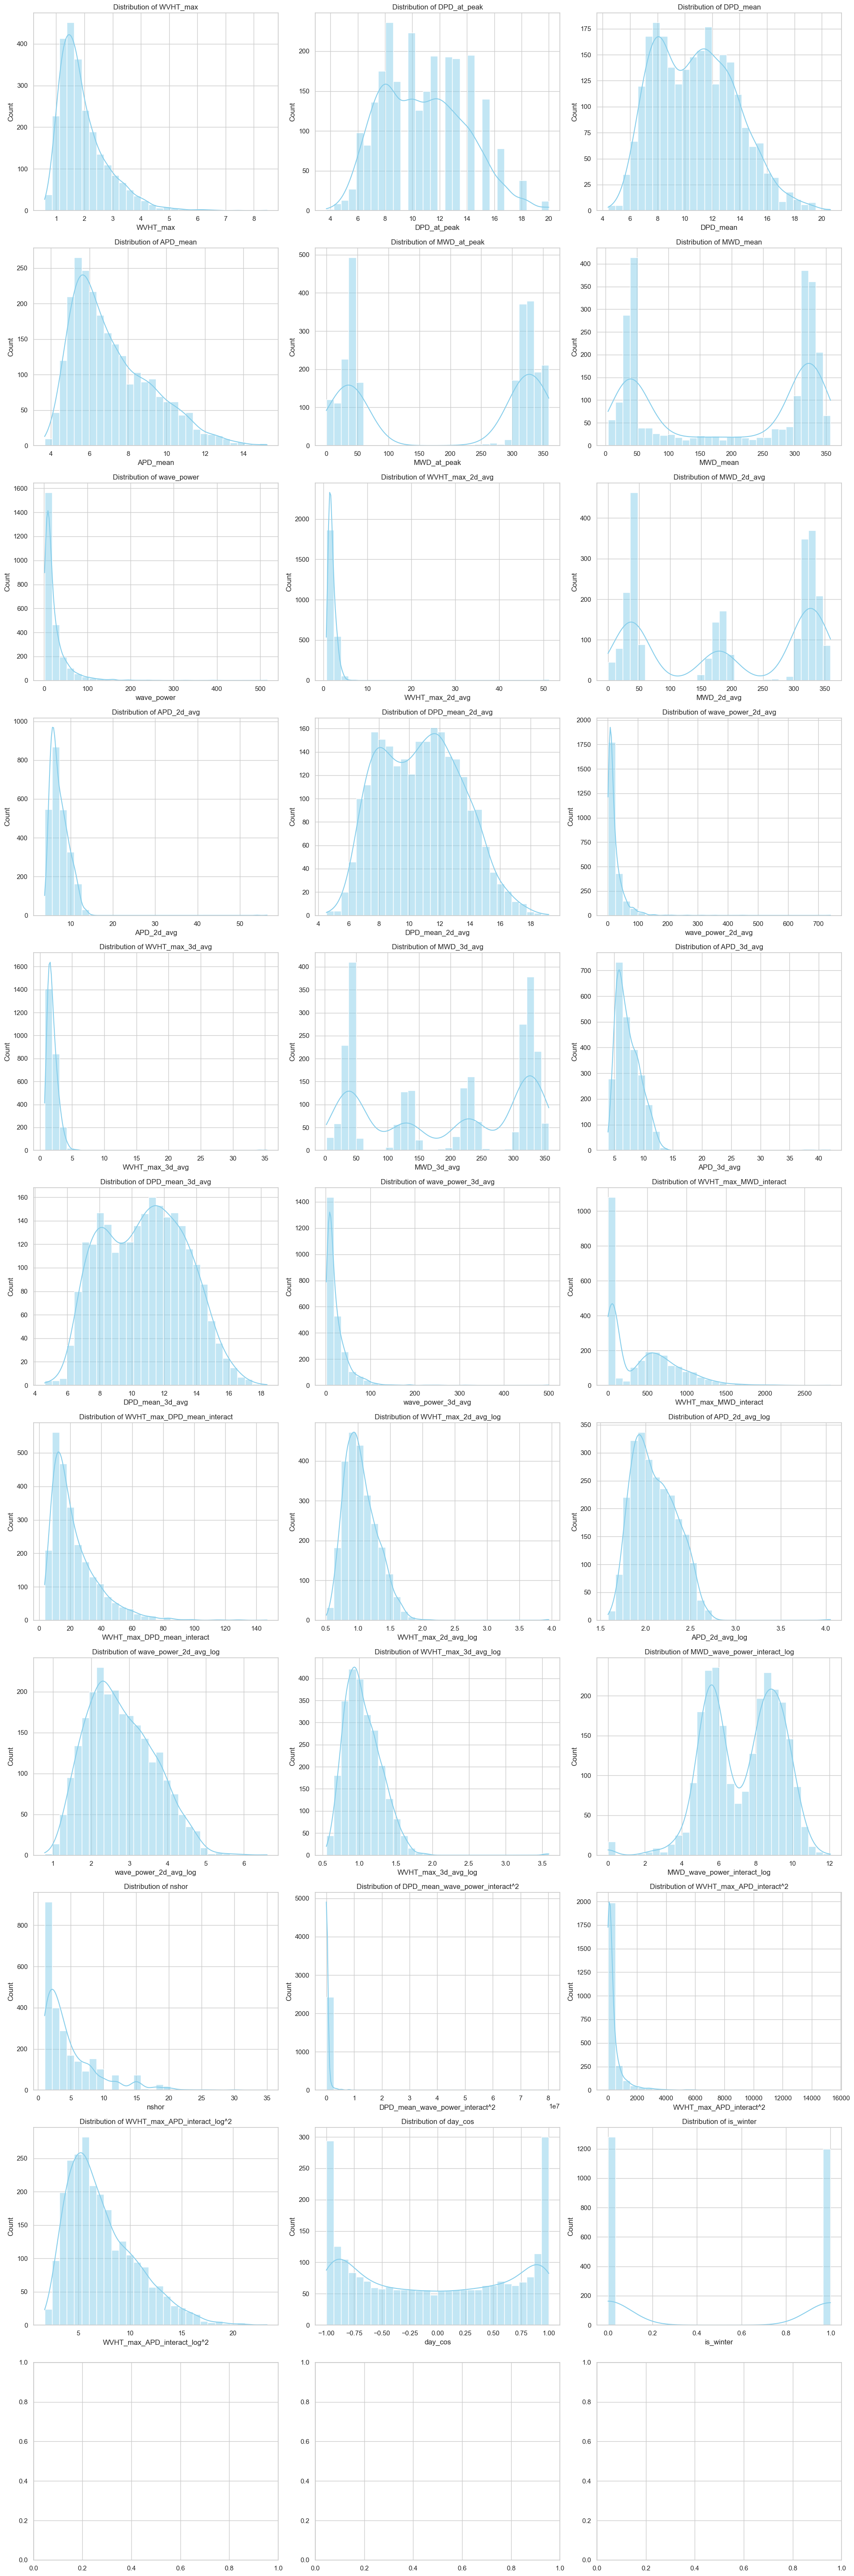

In [4]:
# Select numerical columns for distribution plots
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Plot distributions for each numerical column
fig, axes = plt.subplots(len(numerical_columns)//3 + 1, 3, figsize=(20, len(numerical_columns) * 2))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()


# Time Series Analysis

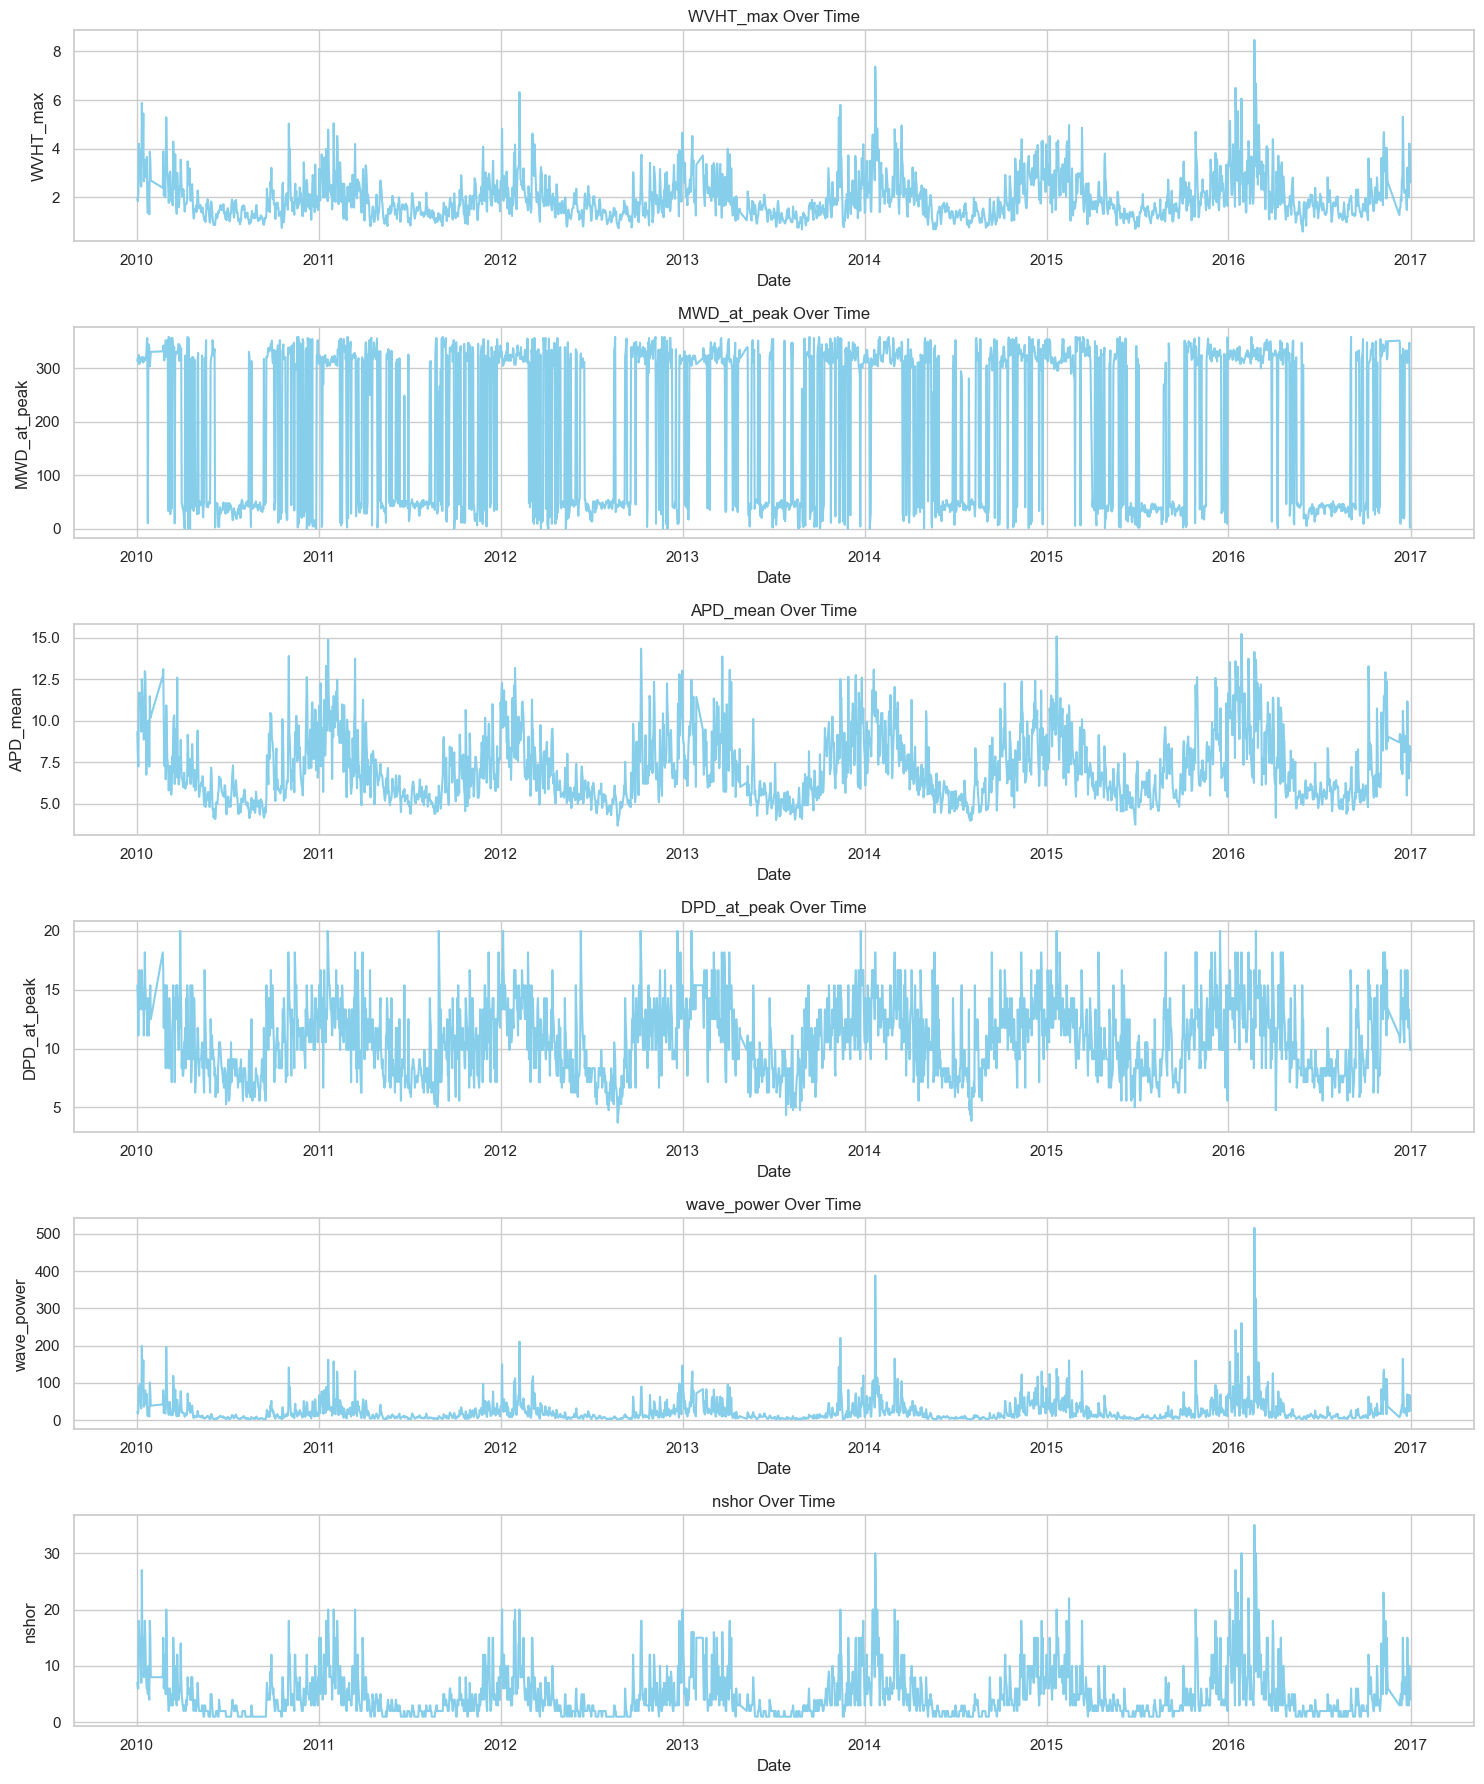

In [5]:
# Plot time series for potentially key variables
key_vars = ['WVHT_max', 'MWD_at_peak', 'APD_mean', 'DPD_at_peak', 'wave_power', 'nshor']

fig, axes = plt.subplots(len(key_vars), 1, figsize=(15, len(key_vars) * 3))

for i, var in enumerate(key_vars):
    axes[i].plot(df.index, df[var], label=var, color='skyblue')
    axes[i].set_title(f'{var} Over Time')
    axes[i].set_ylabel(var)
    axes[i].set_xlabel('Date')

plt.tight_layout()
plt.show()


# Correlation Analysis

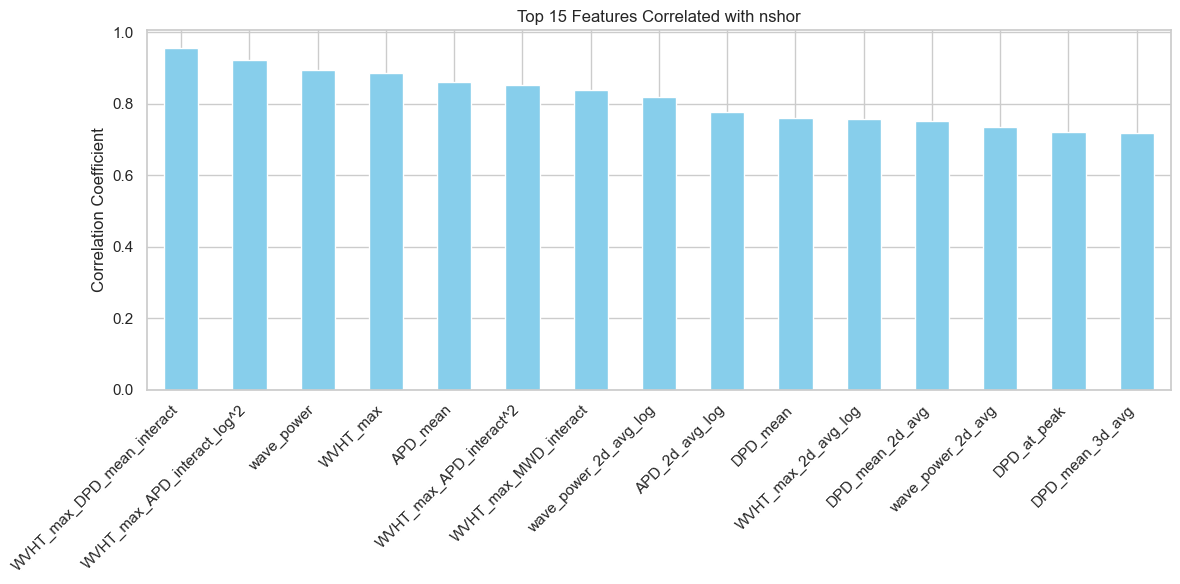

In [6]:
# Correlation with target variable
corr_with_target = df.corr()['nshor'].sort_values(ascending=False)

# Plot top 15 correlations
plt.figure(figsize=(12, 6))
corr_with_target[1:16].plot(kind='bar', color='skyblue')
plt.title('Top 15 Features Correlated with nshor')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

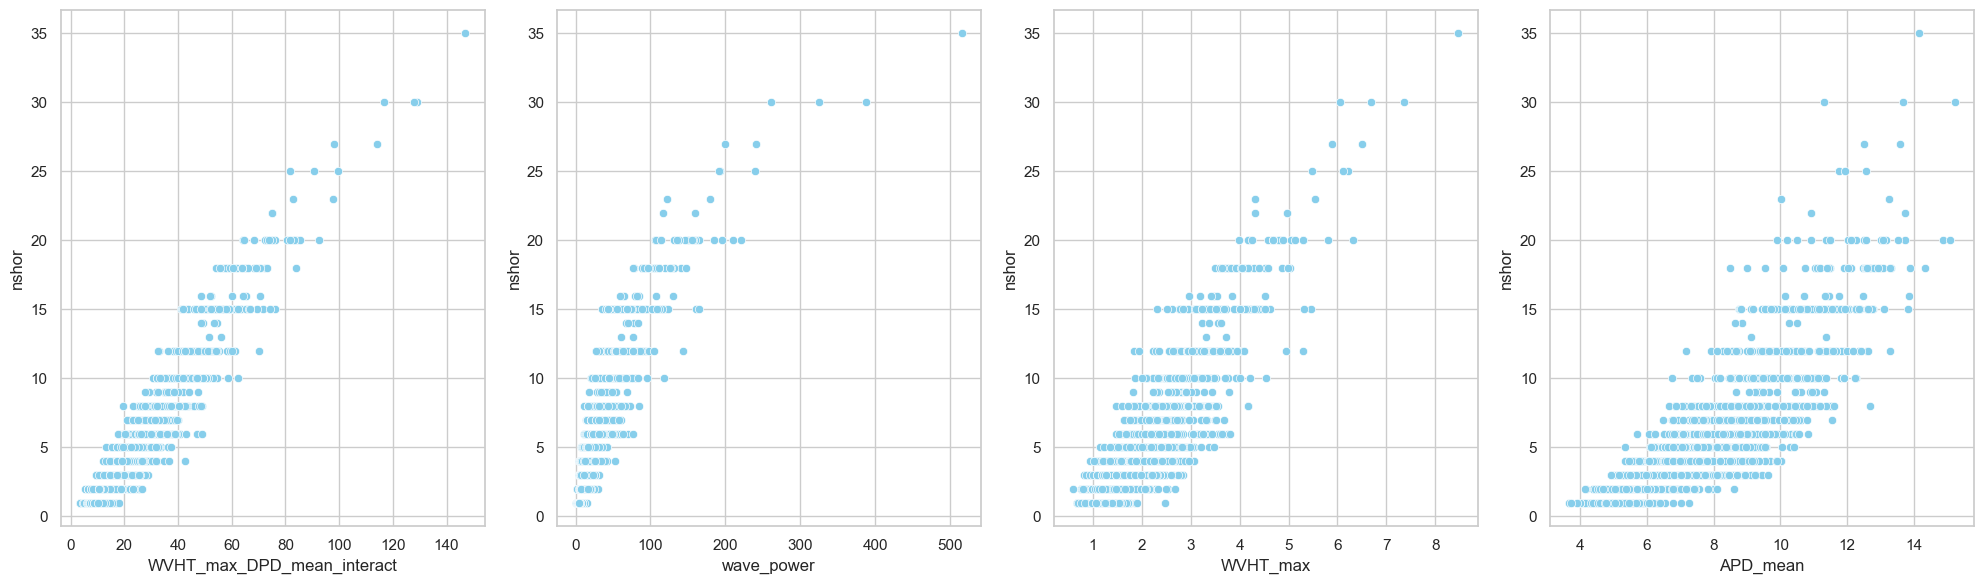

In [7]:
# Scatter plots for key relationships
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
sns.scatterplot(data=df, x='WVHT_max_DPD_mean_interact', y='nshor', ax=axes[0], color='skyblue')
sns.scatterplot(data=df, x='wave_power', y='nshor', ax=axes[1], color='skyblue')
sns.scatterplot(data=df, x='WVHT_max', y='nshor', ax=axes[2], color='skyblue')
sns.scatterplot(data=df, x='APD_mean', y='nshor', ax=axes[3], color='skyblue')
plt.tight_layout()
plt.show()

# Seasonality Analysis

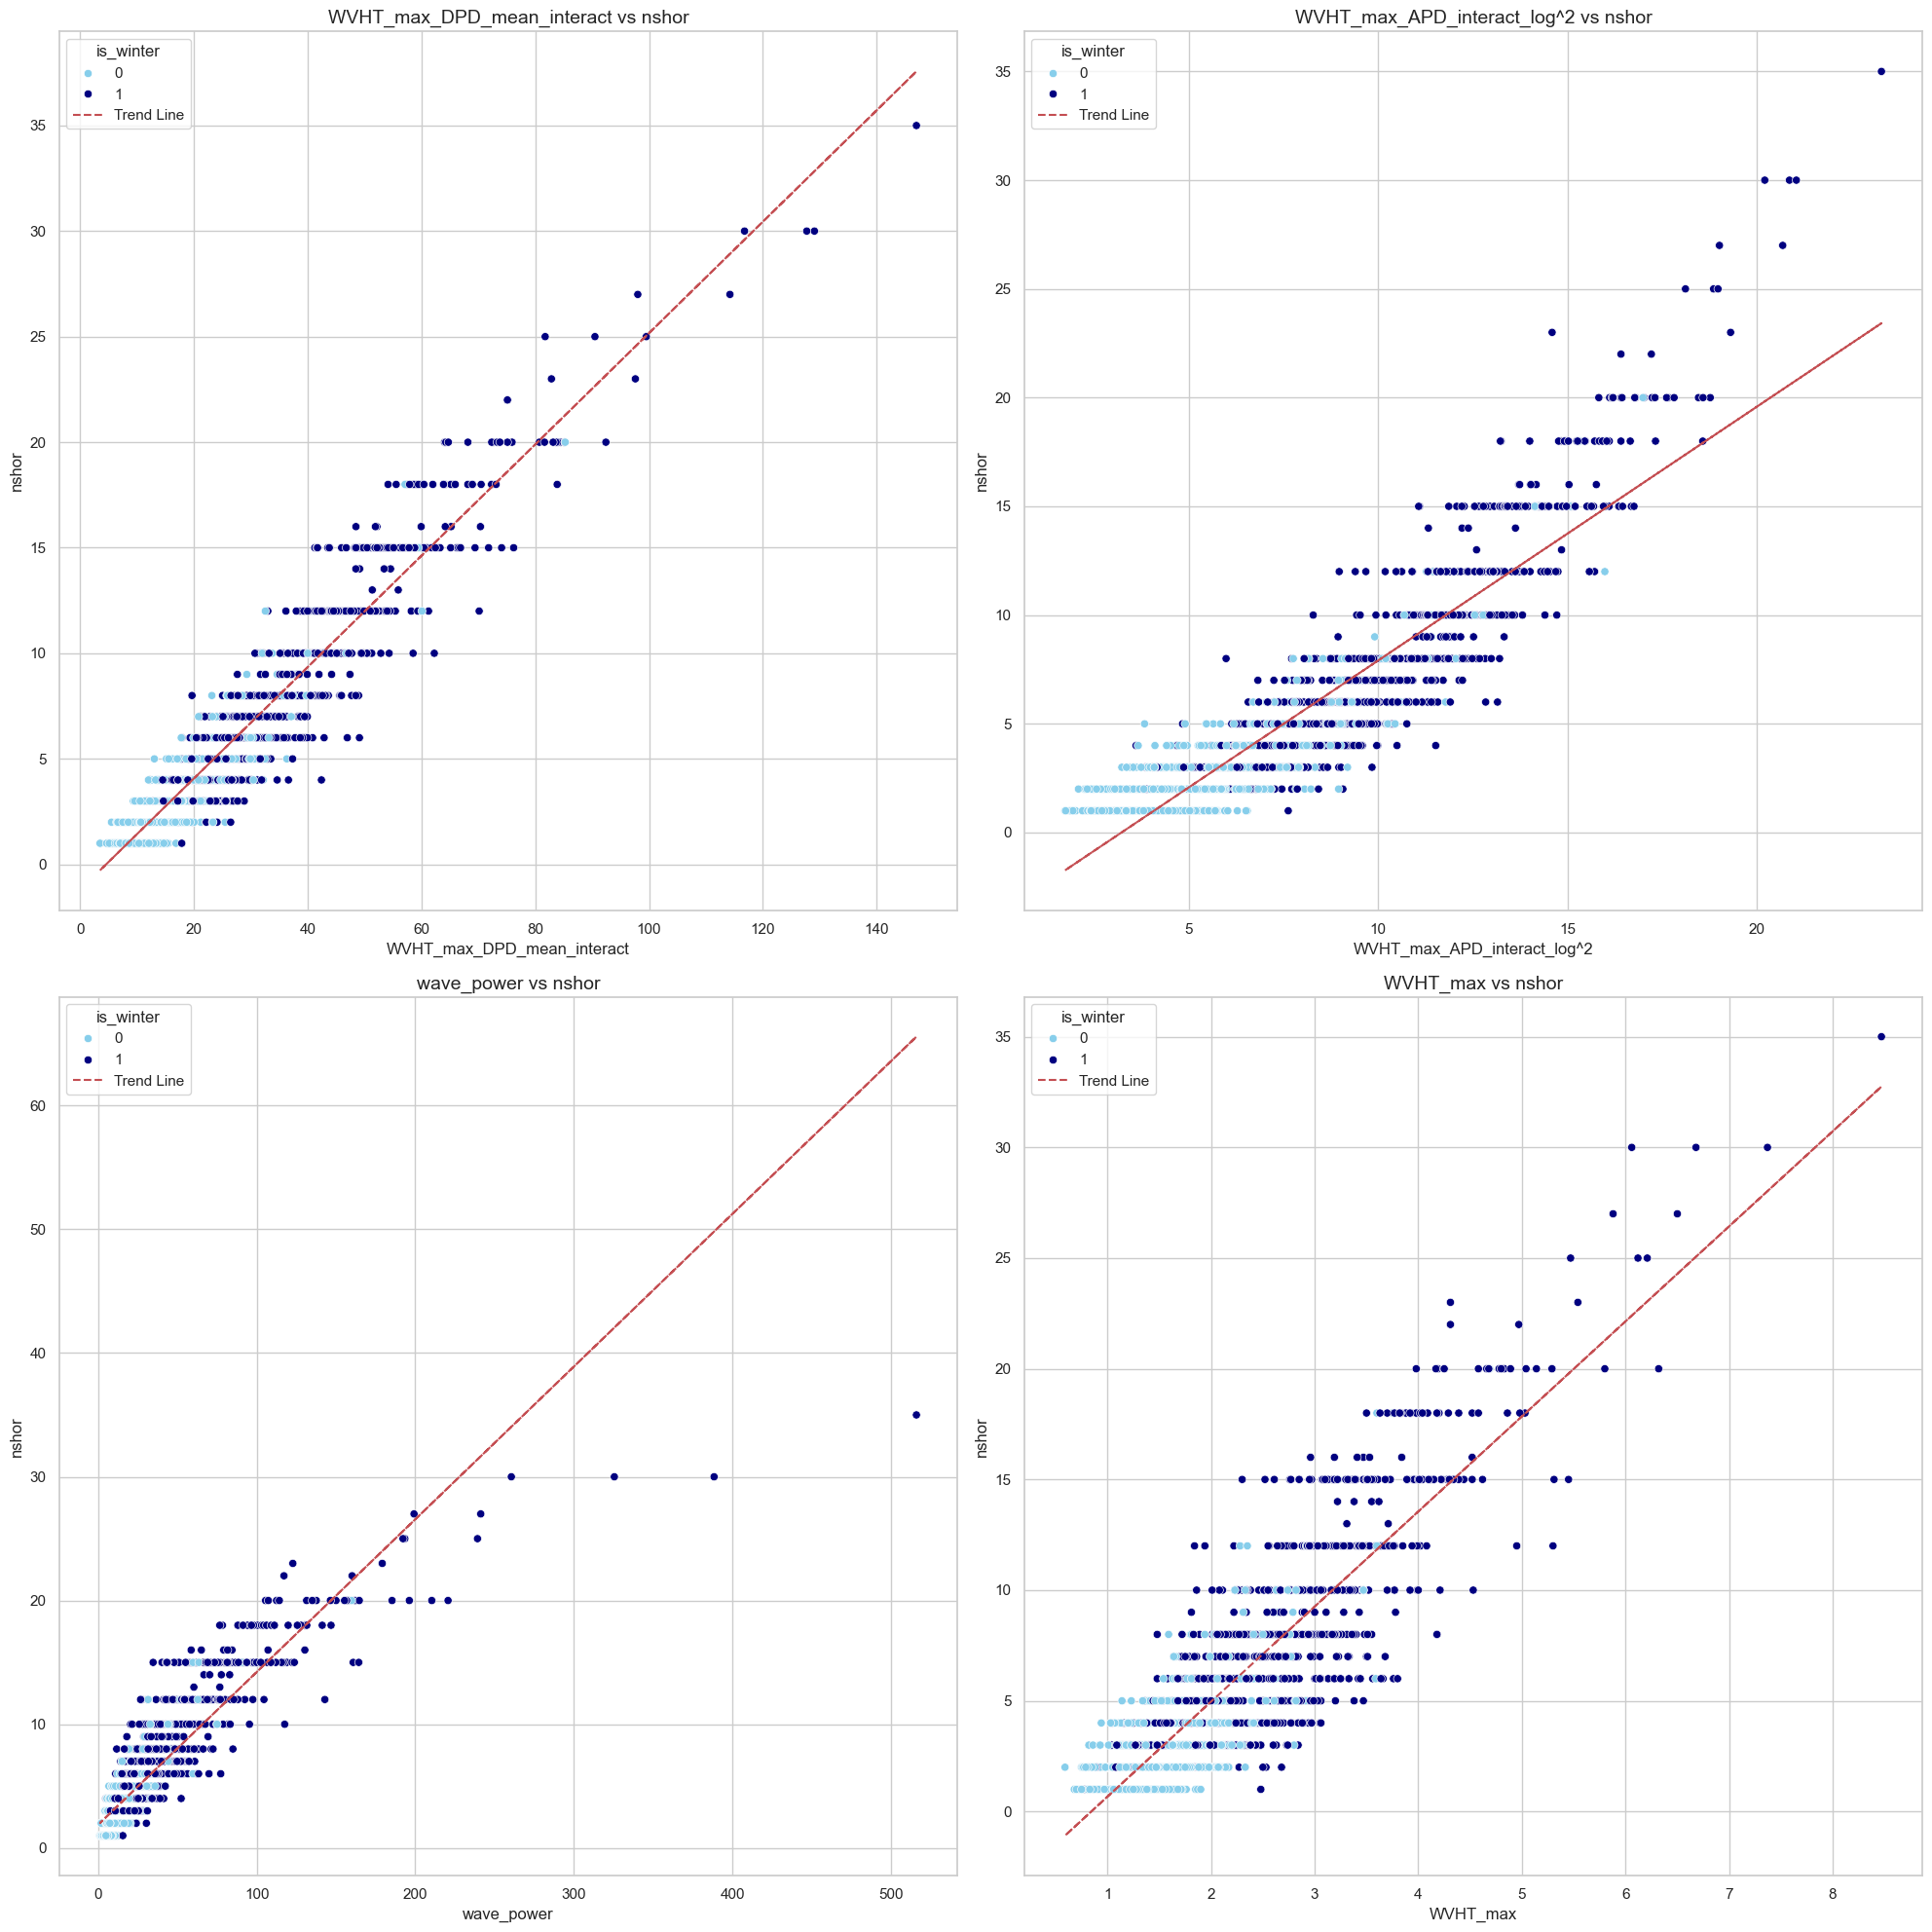

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
axes = axes.ravel()

# Top features are selected based on correlation with target variable 'nshor'
top_features = corr_with_target[1:5].index

# Winter is navy blue
colors = {True: 'navy', False: 'skyblue'}

for i, feature in enumerate(top_features):
    # Scatter plot for seasonal data
    sns.scatterplot(data=df, x=feature, y='nshor', hue='is_winter', palette=colors, ax=axes[i])
    
    # Add trend line
    z = np.polyfit(df[feature], df['nshor'], 1)
    p = np.poly1d(z)
    axes[i].plot(df[feature], p(df[feature]), "r--", label='Trend Line')
    
    # Set plot title and legend
    axes[i].set_title(f'{feature} vs nshor', fontsize=14)
    axes[i].legend(title='is_winter')

plt.tight_layout()
plt.show()


# Distribution of Classes

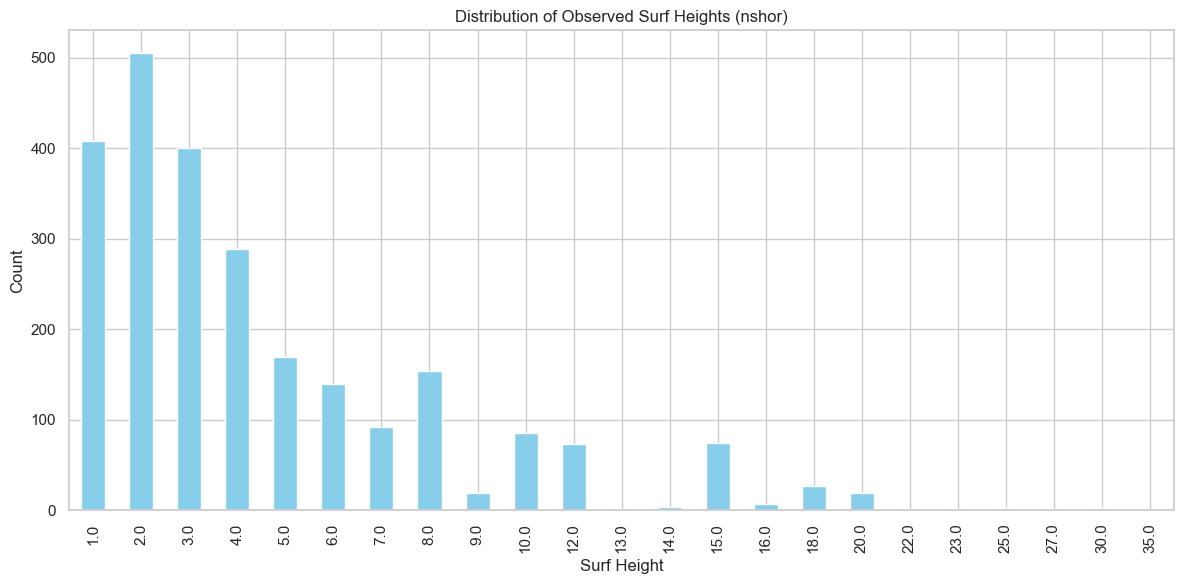

In [9]:
# df.nshor.value_counts()
# Bar plot of nshor distribution
plt.figure(figsize=(12, 6))
df['nshor'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Observed Surf Heights (nshor)')
plt.xlabel('Surf Height')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## Outlier Detection

Number of outliers detected: 25
Percentage of outliers: 1.01%


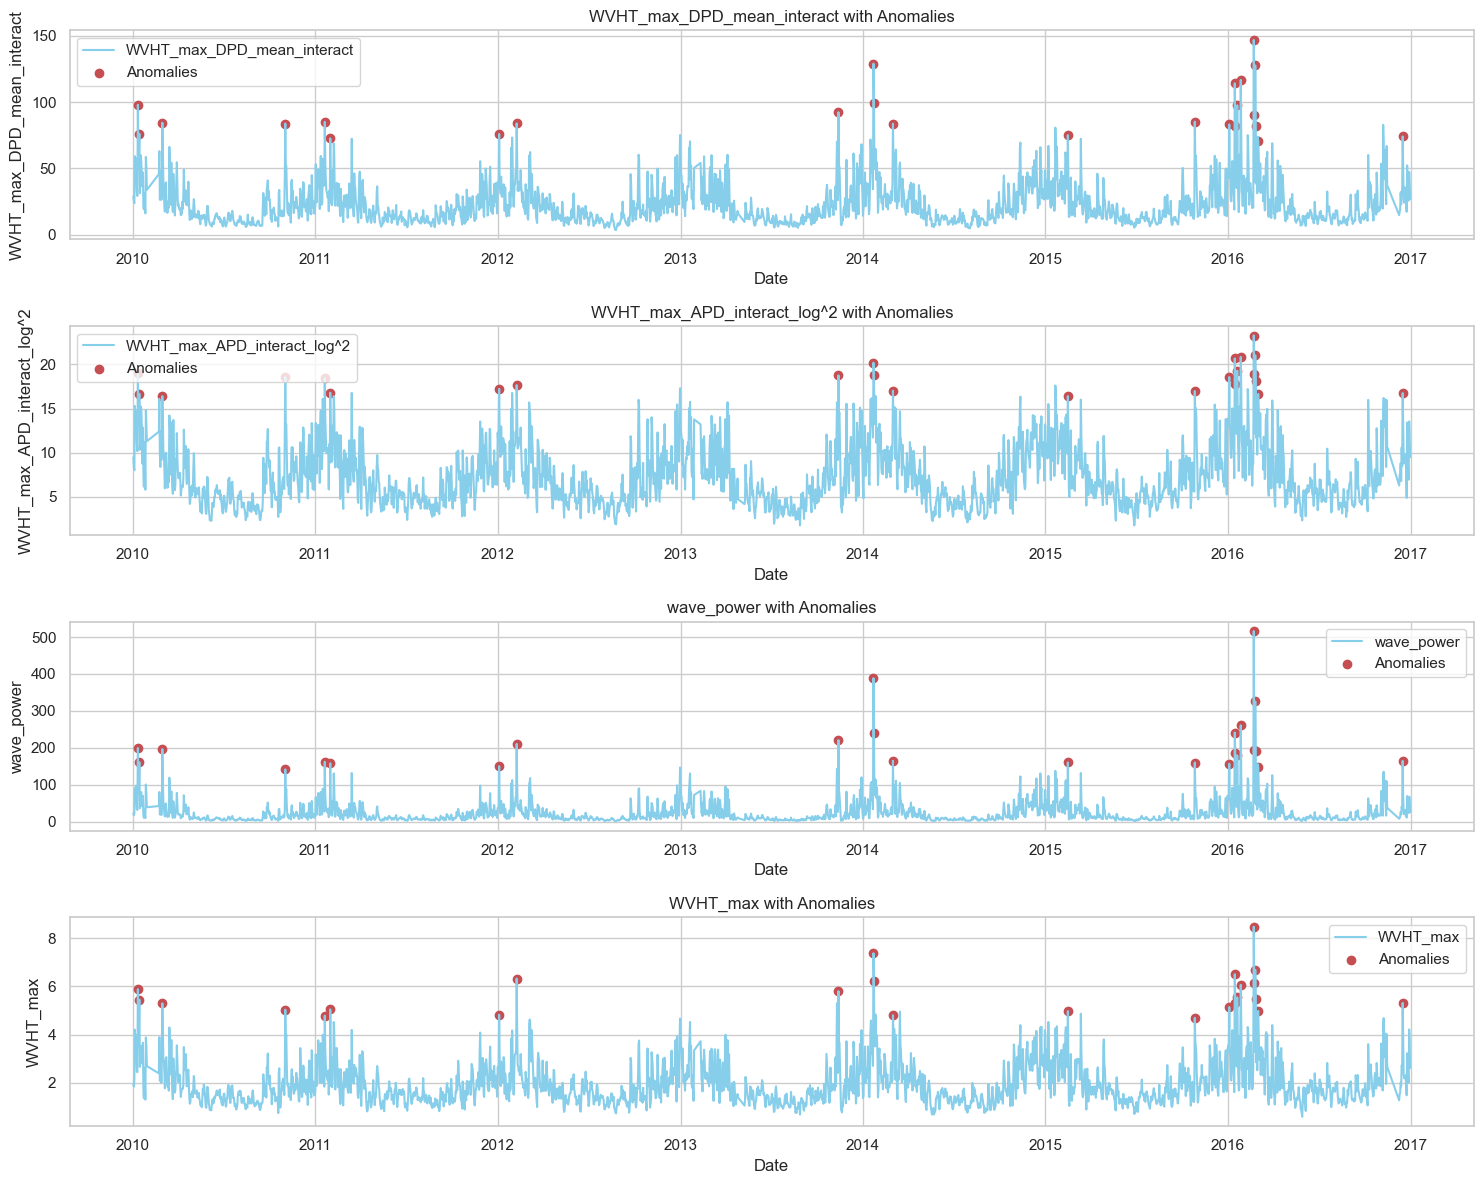

In [10]:
# Fit Isolation Forest model to detect outliers
clf = IsolationForest(contamination=0.01, random_state=42)
df['anomaly_score'] = clf.fit_predict(df[top_features])

# Separate outliers from normal data
outliers = df[df['anomaly_score'] == -1]
normal_data = df[df['anomaly_score'] != -1]

# Summary of the number of outliers
num_outliers = outliers.shape[0]
total_data_points = df.shape[0]
print(f"Number of outliers detected: {num_outliers}")
print(f"Percentage of outliers: {100 * num_outliers / total_data_points:.2f}%")

# Visualize anomalies in time series plot
fig, axes = plt.subplots(len(top_features), 1, figsize=(15, len(top_features) * 3))

for i, var in enumerate(top_features):
    axes[i].plot(df.index, df[var], label=var, color='skyblue')
    
    # Highlight anomalies
    axes[i].scatter(outliers.index, outliers[var], color='r', label='Anomalies')
    
    axes[i].set_title(f'{var} with Anomalies')
    axes[i].set_ylabel(var)
    axes[i].set_xlabel('Date')
    axes[i].legend()

plt.tight_layout()
plt.show()

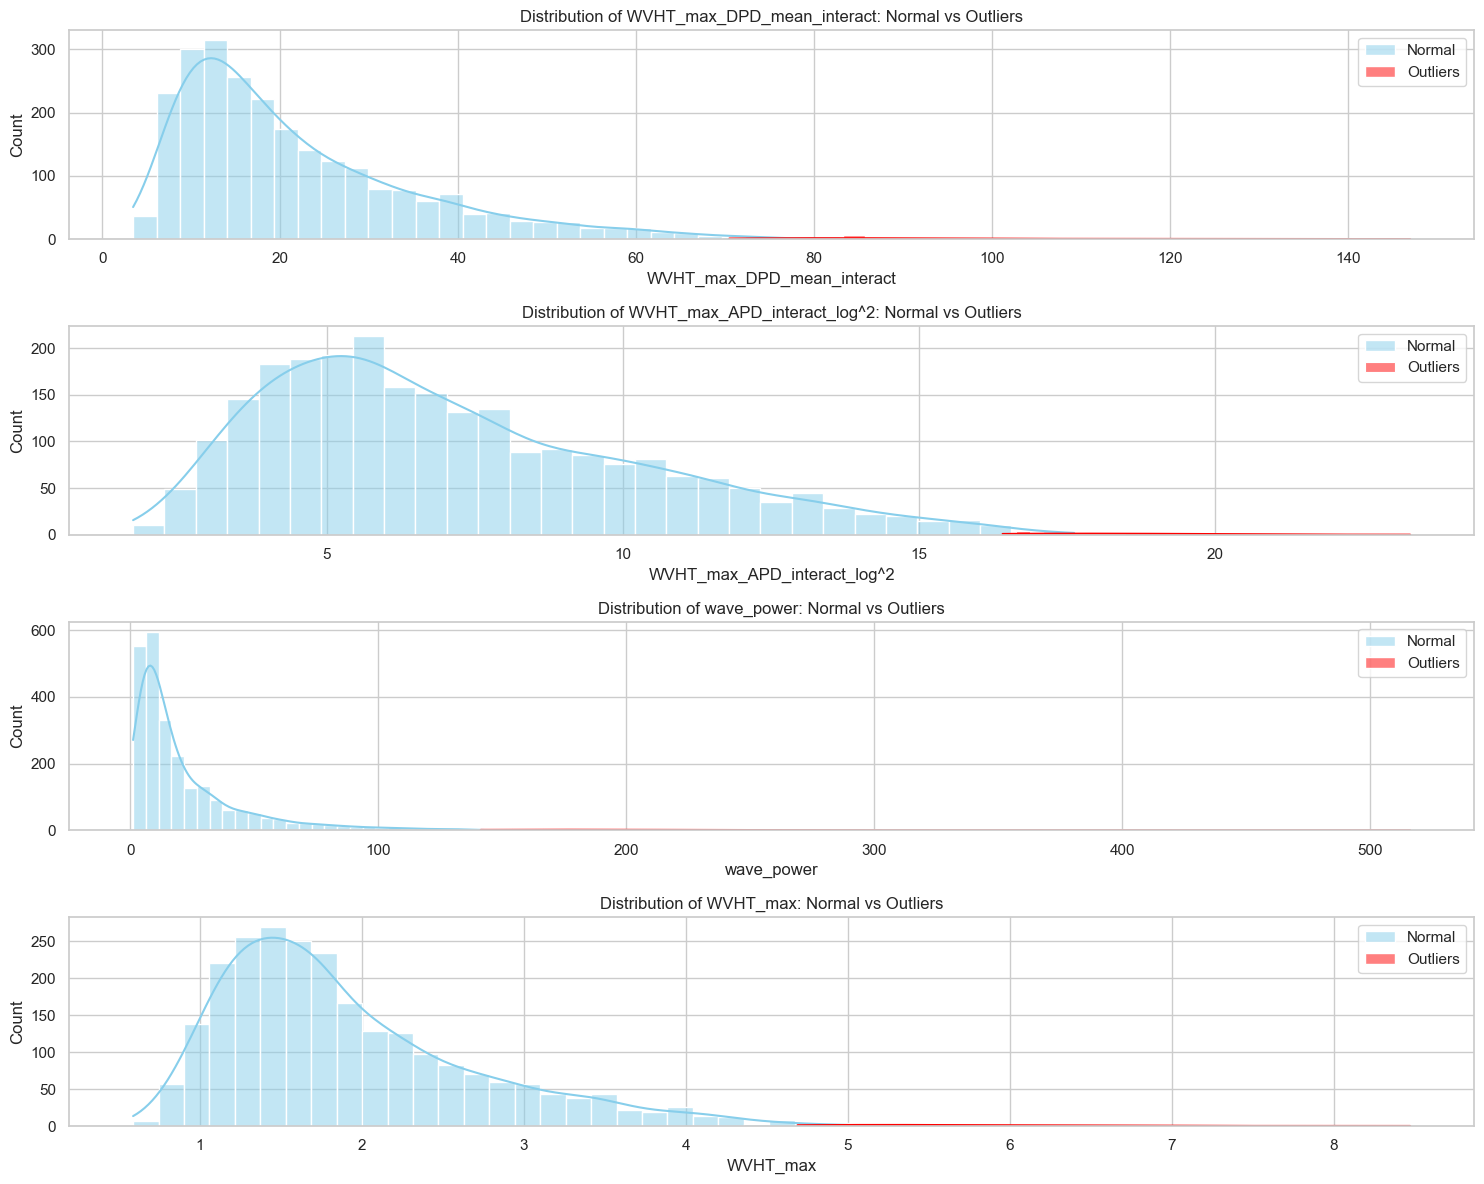

Summary statistics for outliers vs normal data:


,count,mean,std,min,25%,50%,75%,max
WVHT_max_DPD_mean_interact,25.0,92.398815,19.900600,70.481229,81.624700,84.435957,98.019600,147.008400
WVHT_max_APD_interact_log^2,25.0,18.445601,1.739401,16.409109,16.991701,18.456952,19.010276,23.286474
wave_power,25.0,210.880950,85.992554,141.309975,160.160293,185.331671,220.651472,515.988367
WVHT_max,25.0,5.680400,0.898496,4.690000,5.030000,5.450000,6.120000,8.470000


,count,mean,std,min,25%,50%,75%,max
WVHT_max_DPD_mean_interact,2455.0,21.784322,13.576284,3.461527,11.824292,17.696800,28.246324,82.838200
WVHT_max_APD_interact_log^2,2455.0,7.168484,3.155411,1.735471,4.733449,6.447244,9.141996,17.615557
wave_power,2455.0,21.235953,22.712442,1.161745,6.720056,12.369967,27.299064,155.387241
WVHT_max,2455.0,1.908680,0.786064,0.590000,1.330000,1.700000,2.300000,5.300000


In [11]:
# Plot distribution of normal data vs outliers
fig, axes = plt.subplots(len(top_features), 1, figsize=(15, len(top_features) * 3))
for i, var in enumerate(top_features):
    sns.histplot(normal_data[var], bins=30, color='skyblue', label='Normal', ax=axes[i], kde=True)
    sns.histplot(outliers[var], bins=30, color='red', label='Outliers', ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {var}: Normal vs Outliers')
    axes[i].legend()

plt.tight_layout()
plt.show()

# Summary statistics comparison
print("Summary statistics for outliers vs normal data:")
outlier_summary = outliers[top_features].describe().T
normal_data_summary = normal_data[top_features].describe().T

display(outlier_summary)
display(normal_data_summary)